In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torchvision import transforms
import random
import os
from PIL import Image
import numpy as np
import torchvision.transforms.functional as F

# Model

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ResidualBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.norm1 = nn.InstanceNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
        self.norm2 = nn.InstanceNorm2d(out_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.norm1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.norm2(out)
        out = self.relu(out)

        #out += residual  # Add the residual
        return out

In [3]:
class AdvancedStyleTransferModel(nn.Module):
    def __init__(self):
        super(AdvancedStyleTransferModel, self).__init__()

        # Initial convolution input image size=3x64x64
        self.conv1 = nn.Conv2d(3, 32, kernel_size=4, stride=1, padding=2)  # 32x64x64
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(32, 128, kernel_size=2, stride=1, padding=1)  # 128x32x32
        self.relu2 = nn.ReLU()
    

        self.conv_transpose1 = nn.ConvTranspose2d(128, 32, kernel_size=2, stride=1, padding=1)  # 32x64x64
        self.relu3 = nn.ReLU()

        self.conv_transpose2 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=1, padding=2)
        self.relu4 = nn.ReLU()
        
        # Residual blocks
        self.residual_blocks = ResidualBlock(32, 32)
                                        
        
        

    def forward(self, x):
        resu = x
        out = self.relu1(self.conv1(x))
        #out = self.batch_norm1(out)
        out = self.residual_blocks(out)
        out = self.relu2(self.conv2(out))
        #out = self.batch_norm2(out)
        #out = self.residual_blocks(out)
        out = self.relu3(self.conv_transpose1(out))
        out = self.conv_transpose2(out)
        #out = self.batch_norm2(out)
        # out += resu
        return out

In [4]:
model_url=r'models\model_final_train_loss_0.1172_val_loss_0.1181.pth'
test_folder_path=r'dataset\test'

In [5]:
model_dict = torch.load(model_url, map_location=torch.device('cpu'))
model = AdvancedStyleTransferModel()
model.load_state_dict(model_dict)

<All keys matched successfully>

# cut image

In [6]:
input_image_url=r'C:\Users\prabh\Desktop\pexels-suneo-103573.jpg'
input_image=Image.open(input_image_url).convert('RGB')

In [7]:
patch_size = [256, 256]

In [8]:
def de_norm(img):
  denormalize = transforms.Normalize(mean=[-m/s for m, s in zip(mean, std)], std=[1/s for s in std])
  return denormalize(img)

In [9]:
mean = [0.485, 0.456, 0.406]  # RGB mean values
std = [0.229, 0.224, 0.225]
normalize=transforms.Normalize(
    mean=mean, std=std
)

transform_test=transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    normalize
])

In [38]:
patches = []
for i in range(0, input_image.height, patch_size[1]):
    for j in range(0, input_image.width, patch_size[0]):
        patch = input_image.crop((j, i, j + patch_size[0], i + patch_size[1]))
        patch=transform_test(patch)
        stylized_patch = model(patch)
        stylized_patch=de_norm(stylized_patch)
        patches.append(stylized_patch)
  

In [ ]:
output_image = Image.new("RGB", input_image.size)
patch_index = 0
for i in range(0, input_image.height, patch_size[1]):
    for j in range(0, input_image.width, patch_size[0]):
        output_image.paste(patches[patch_index], (j, i))
        patch_index += 1


In [33]:
from IPython.display import display

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


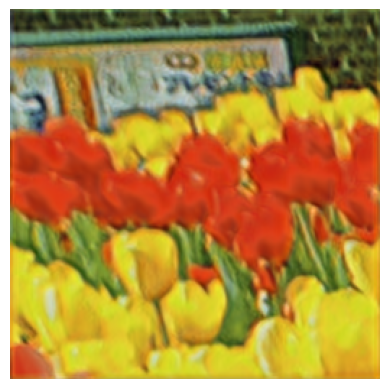

In [37]:
image_to_display = patches[0].clone().detach().cpu().squeeze().permute(1, 2, 0)

# Display the image using matplotlib
plt.imshow(image_to_display)
plt.axis('off')
plt.show()